<a href="https://colab.research.google.com/github/SergeiVKalinin/MSE_Fall2024/blob/main/Module_4/Homework_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Homework 6 for the Fall 2024 Course "Machine Learning for Materials Science", University of Tennessee Knoxville, Department of Materials Science and Engineering.

- Instructor Sergei V. Kalinin
- EELS data by Kevin Roccapriore, Oak Ridge National Laboratory

Special point:
- ChatGPT will augment your power as a coder
- If and only if you know what you want to accomplish!

# Imports

0. Add imports as necessary

In [ ]:
from copy import deepcopy as dc

import numpy as np
from sklearn import decomposition

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Problem 1 - PCA

1. Create the data set:
- Import the MNIST data set (from Keras)
- Select the images corresponding to single digit (e.g. 7)
- Run the PCA analysis on images

2. Visualize the scree plot

3. Visualize the PCA components and loadings distribution (the first two components)

4. Generative model:
- run the PCA analysis with 2 components
- sample the loading space with the rectangular grid
- generate the images from the loading space (i.e. create latent representation)
- do you observe any trends in images across the loading space?

5. In the PCA generative model, each image is represented by 2 PCA loadings. Where does the information to "reconstruct" images come from?

Answer 5:

6. (Optional). Create a function that analyzes the "writing style" of the reconstructed image, meaning function transforming (image) -> (several scalar descriptors). For example, it can be the tilt and axis ratio of the tensor of moments of inertia for binarized image. Map this function over the latent space of the model.

# Problem 2 - LDA

7. Here, we will run the LDA on the MNIST data set.
- Identify (any) 3 digits that you would like to explore and assign as classes 1, 2, and 3
- Designate all other digits as class 0
- Run the LDA analysis
- If the analysis takes too long (>5 min), decimate the data set as [::10]

8. Visualize the LDA results in the 2D LDA feature space. Use the original digits as labels

9. Run the analysis when the selected classes are "0", "1", and "8". Where will be the "6" and "9" in the LDA feature space

Answer 9:

# Problem 3 - QDA on EELS

Download EELS data. This is 12 EELS spectral data sets of indium-tin oxide cubes aquired by Kevin Roccapriore, measured at different resolutions and geometries. Pick the one you like!

In [ ]:
%%capture
!wget https://www.dropbox.com/s/nicyvttpihzh1cd/Plasmonic_sets_7222021_fixed.npy
loadedfile = np.load("Plasmonic_sets_7222021_fixed.npy", allow_pickle=True).tolist()

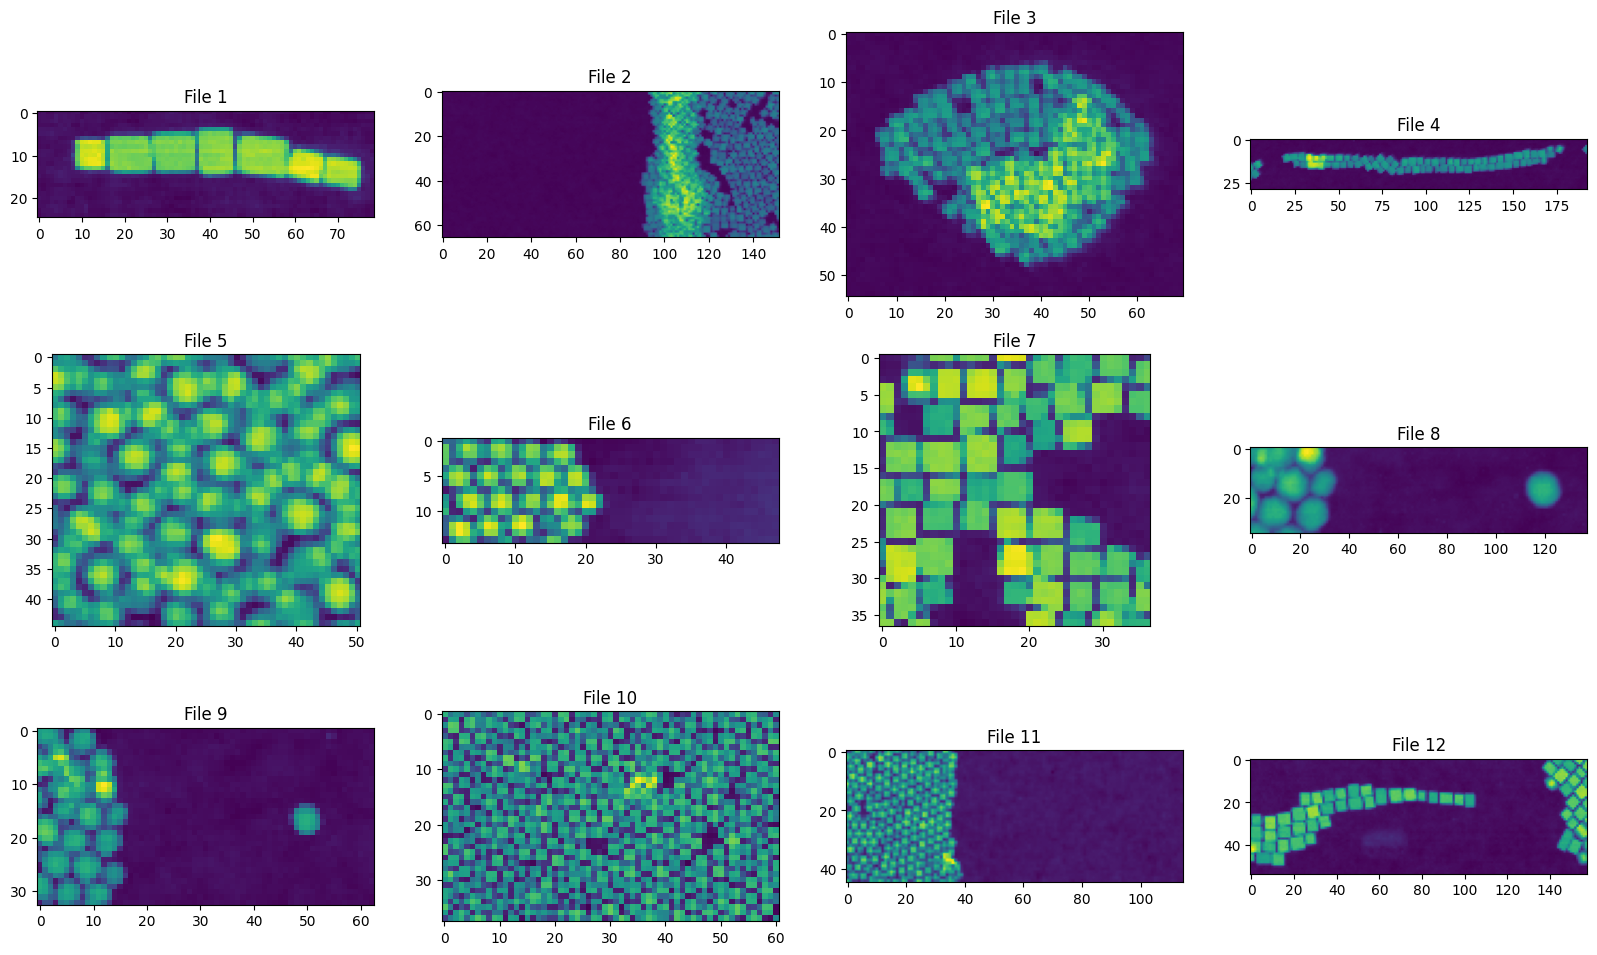

In [ ]:
num_im = len(loadedfile)
rows = int(np.ceil(float(num_im)/4))
cols = int(np.ceil(float(num_im)/rows))

gs = gridspec.GridSpec(rows, cols)
fig = plt.figure(figsize = (5*cols, 3*(1+rows)))

for kk in range(num_im):
    ax = fig.add_subplot(gs[kk])
    fileset  = loadedfile['{}'.format(kk+1)]
    f1,f2,f3,f4 = fileset
    img, data, e_ax, img_scale = fileset[f1], fileset[f2], fileset[f3], fileset[f4]
    ax.imshow(img)
    ax.set_title("File {}".format(kk+1))

In [ ]:
# Choose the file for analysis

k = 3
img = loadedfile['{}'.format(k)]['image']
specim = loadedfile['{}'.format(k)]['spectrum image']
e_ax = loadedfile['{}'.format(k)]['energy axis']
imscale = loadedfile['{}'.format(k)]['scale']

In [ ]:
# Read grid spectoscopy data

hdata = specim
hdata = hdata.astype(np.float64)

Visual inspection of the :

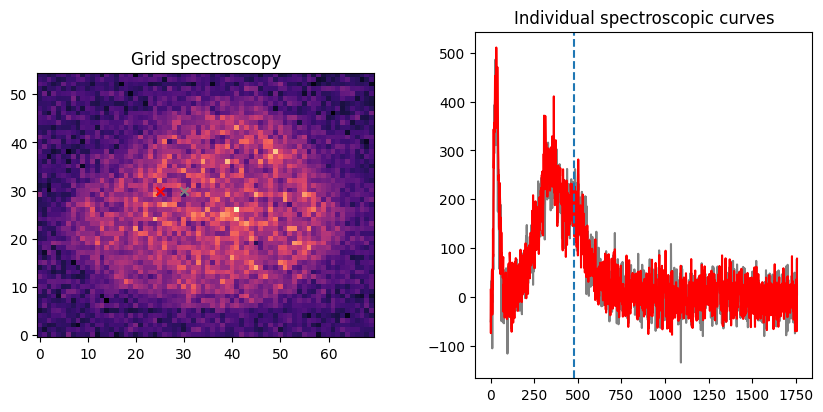

In [ ]:
# Select a slice and points for extracting idividual spectoscopic curves
# For convenience, we look at the data in pixels (however, we store the real scale as e_ax)

s = 480 # slice
pos1 = [30, 30]
pos2 = [25, 30]

# Plot
_, ax = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(hdata[..., s], cmap='magma', origin="lower")
ax[0].scatter(pos1[0], pos1[1], c='gray', marker='x')
ax[1].plot(hdata[pos1[1], pos1[0], :], c='gray')
ax[0].scatter(pos2[0], pos2[1], c='red', marker='x')
ax[1].plot(hdata[pos2[1], pos2[0], :], c='red')
ax[1].axvline(x=s, linestyle = '--')
ax[0].set_title('Grid spectroscopy')
ax[1].set_title('Individual spectroscopic curves')
plt.subplots_adjust(wspace=.3)

Important considerations for subsequent analysis.
 - For "real" analysis, make sure that before any subsequent analysis the data is properly curated. For EELS this is zero loss peak subtraction and log-log deconvolution. This will affect analysis very strongly (e.g. zero-loss peak will dominate everything if not accounted for).
 - You can also consider downsampling the data (just average pool).
 - Finally, always keep track on whether you normalize data and how (all spectra 0 to 1, or all normalized to total maximum)
 - And keep track on whether average is subtracted.
 - Normalization and average subtraction will affect the analysis results. In our experience, there is no right way or wrong way for doing it - different preprocessing highlights dissimilar aspects of the physics of the system. However, it is important to keep track of these.  

In [ ]:
X_vec = hdata.copy()
d1, d2, d3 = X_vec.shape
X_vec = X_vec.reshape(d1*d2, d3)
X_vec = (X_vec - np.min(X_vec)) / np.ptp(X_vec)

In [ ]:
d1, d2, d3

(55, 70, 1758)

Here we run the PCA analysis on EELS to visualzie the results

In [ ]:
# Select number of components
nc = 12

# Select decomposition type ('PCA' or 'NMF')
decomposition_type = 'PCA'

# Run decomposition
if decomposition_type == 'NMF':
    clf = decomposition.NMF(n_components=nc, random_state=42)
elif decomposition_type == 'PCA':
    clf = decomposition.PCA(n_components=nc, random_state=42)
else:
    raise NotImplementedError('Available methods: "PCA", "NMF"')
X_vec_t = clf.fit_transform(X_vec)
components = clf.components_
components = components.reshape(nc, d3)
print(components.shape, X_vec_t.shape)

(12, 1758) (3850, 12)


NUMBER OF COMPONENTS: 12
Components...


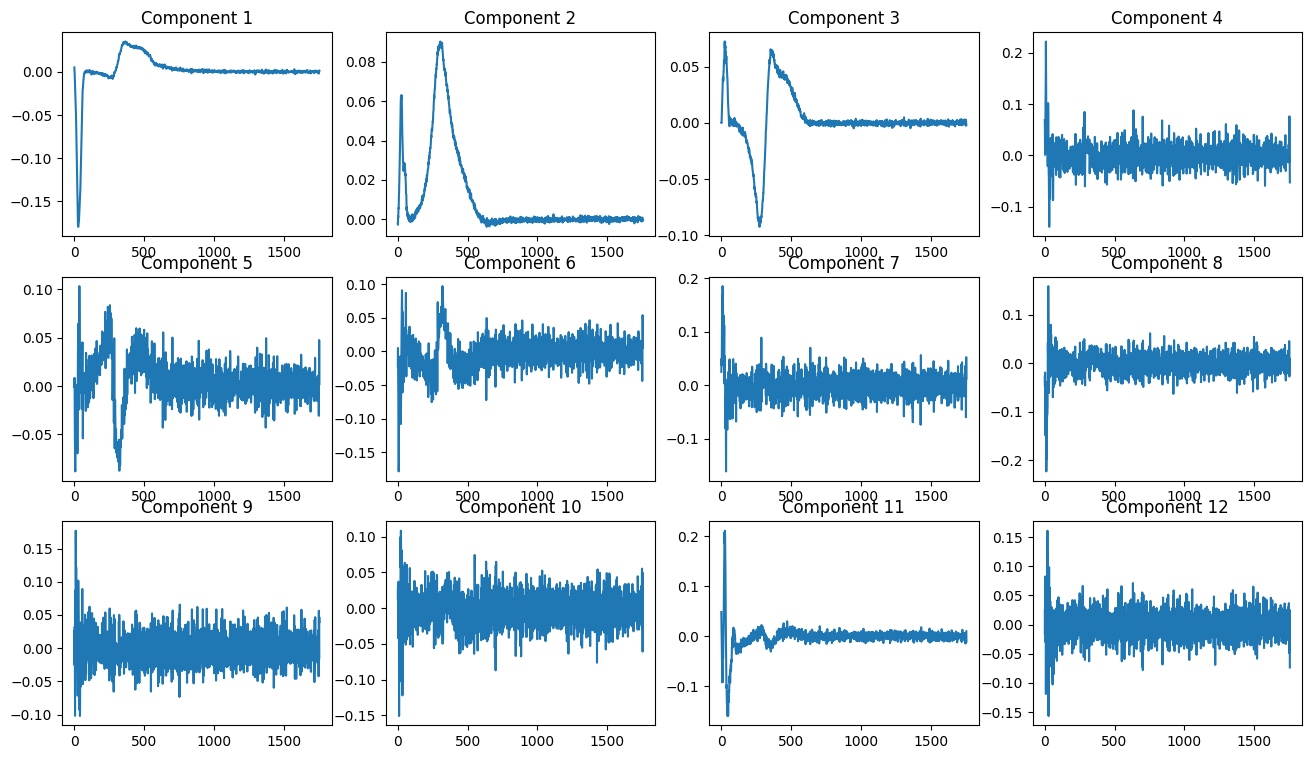

Abundance maps...


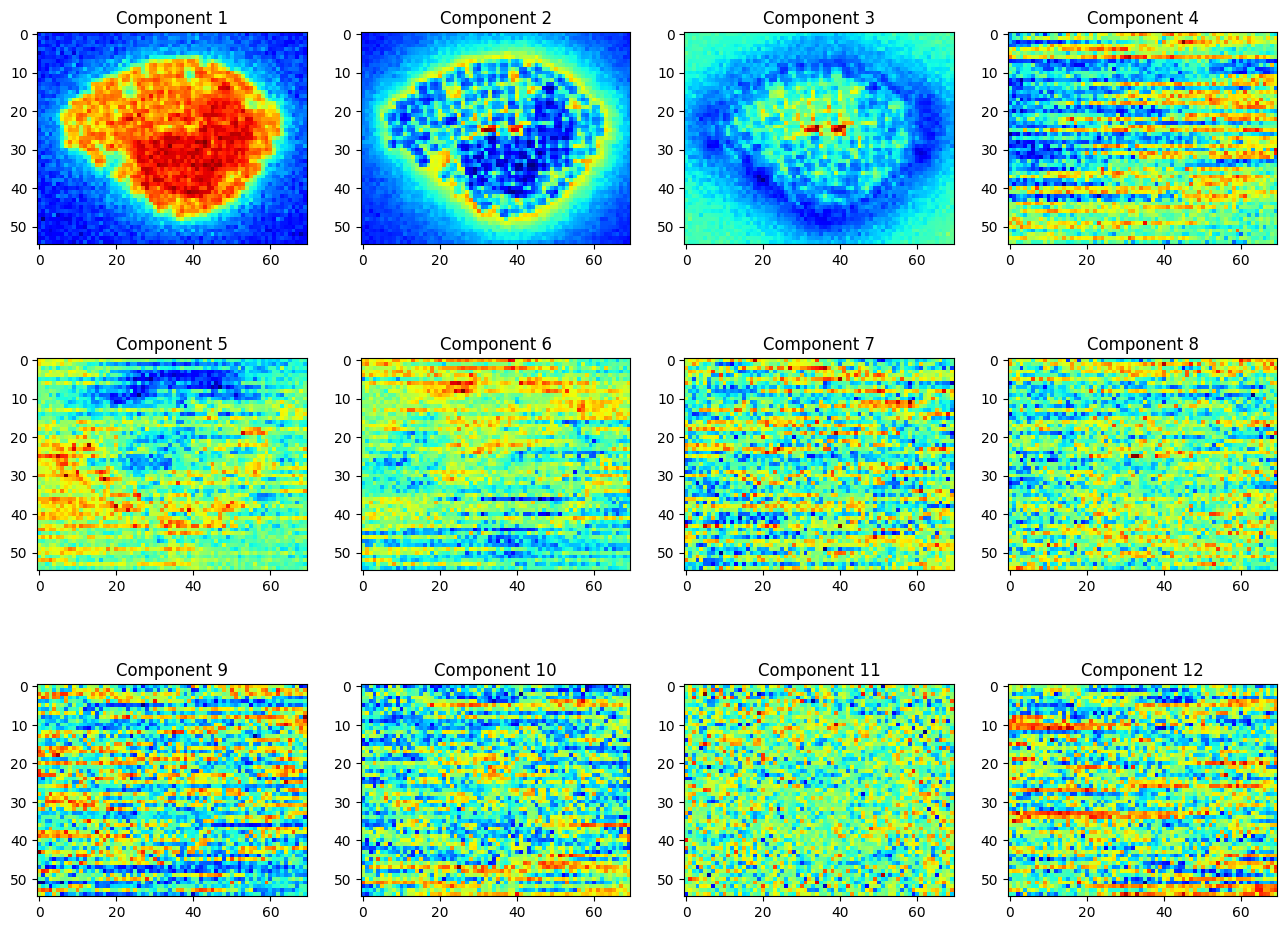

In [ ]:
rows = int(np.ceil(float(nc)/5))
cols = int(np.ceil(float(nc)/rows))

print('NUMBER OF COMPONENTS: ' + str(nc))
print('Components...')
gs1 = gridspec.GridSpec(rows, cols)
fig1 = plt.figure(figsize = (4*cols, 3.5*(1+rows)//1.5))
for i in range(nc):
    ax1 = fig1.add_subplot(gs1[i])
    j = 0
    ax1.plot(components[i])
    ax1.set_title('Component ' + str(i + 1))
plt.show()

print('Abundance maps...')
gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))
for i in range(nc):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(X_vec_t[:, i].reshape(d1, d2), cmap = 'jet')
    ax2.set_title('Component ' + str(i + 1))
plt.show()

10. Let's explore the QDA analysis on the EELS data set. Here, as a first step we need to create meaningful class labels. There are multiple ways we can make them based on the prior knowledge, physical intuition, or curiosity. Here, pick one of the three ways:
- Using the PCA images as a guide, identify ~10 points/class as class 1, 2, ... . Note that one class should be in the empty space (e.g. point (0,0) and few similar ones). Others can be identified as corners of the nanoparticle clusters, etc. In other words, we identify possible classes for spectra based on structural similarity of images
- We can also use the PCA maps to help "identify" classes. For example, using the peak finding function to identify dark/bright points on one of the PCA maps
- The output will be the 2D array of the same size as the the image, with most of the points having class label 0 and others being class labels 1, 2, ...


11. Run the QDA analysis on the selected classes (meaning ignore the class 0 points)

12. Using the trained QDA model, classify the remaining spectra. Visualize the class labels image

# Problem 4 - MLR on EELS

Now, let's run the multiple regression analysis on the EELS data set. Here, we represent each EELS spectrum A(x,y,E) as a linear combination of endmember spectra A_i(E), i.e. try to find linear coefficients a1, a2, ... , an in A(x,y,E) = a1(x,y) A_1(E) + a2(x,y) A_2(E) + ... + an(x,y) A_n(E). Unlike the PCA analysis, the endmembers A_i(E) are **known**.

13. Create the endmembers by averaging within the classes that you created above

14. Create the function that takes unknown spectrum A(E) and known endmember spectra A_i(E), and fits A(E) with linear function A(x,y,E) = a1(x,y) A_1(E) + a2(x,y) A_2(E) + ... + an(x,y) A_n(E) to yield the constants a1, ..., an and fit error. Show the results of the fit for several points.

15. Apply this function to the chosen EELS data set and visualize the results, i.e. the maps of coefficients a_i(x,y) and error map.